<a href="https://colab.research.google.com/github/unterbrink/LinkedInGender/blob/main/LinkedInGenderBalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: for this project I used Colab, a free interactive notebook provided by Google Cloud. Colab is typically used for Python, but can also be used for R. The easiest way is to visit https://colab.to/r, which will create an R notebook (don't worry about the ipynb extension). 

# Step 1: Get LinkedIn data
Download your connections data from LinkedIn[(1)](https://www.linkedin.com/help/linkedin/answer/a566336/export-connections-from-linkedin?lang=en). Once you reqeuest the data, it will take about 10' for the file to be ready for download.

# Step 2: Install packages

In [ ]:
# install gender package to predict names from historical data [2]
# install janitor package to clean up variable names
install.packages("gender")
install.packages("janitor")
remotes::install_github("lmullen/genderdata")

In [ ]:
library(gender) # gender
library(ggplot2) # graphs
library(lubridate) # manipluate dates
library(dplyr) # manipulate data
library(readr) # importing the LinkedIn data
library(janitor) # clean up variable names
library(stringr) # dealing with strings
library(tidyr) # data wrangling for graphs

# Step 3: Upload and clean data
Download your connections data from LinkedIn [2].

Upload your LinkedIn Data Export. If you've downloaded it you can use the GUI. Rename the file to **LIData.zip**.

In [ ]:
# The LinkedIn file has 3 rows we will omit:
## Row 1: "Notes"
## Row 2: "When exporting your connection data, you may notice that some of the email addresses are missing. You will only see email addresses for connections who have allowed their connections to see or download their email address using this setting https://www.linkedin.com/psettings/privacy/email. You can learn more here https://www.linkedin.com/help/linkedin/answer/261"
## Row3: Blank
## Use "skip = 3" to ignore these rows
LIdata <- read_csv("LIData.zip", skip = 3)

In [ ]:
# Cleaning up variable names to remove spaces and capitalization
LIdata <- clean_names(LIdata)

In [ ]:
# Check out the data
head(LIdata)
summary(LIdata)

In [ ]:
# Check for missing data
colMeans(is.na(LIdata))

In my data, < 1% were missing first and last names, 99% were missing email, and 1% were missing company and position. Drop data without first name (on review of the raw data, it looks like these are people who have left LinkedIn -- only connection date is present for these rows).

In [ ]:
# Clean up data
LIdata <- LIdata %>% 
  filter(!is.na(first_name)) %>% # Filter out rows where first_name is missing
  mutate(connected_on = lubridate::dmy(connected_on), # Convert connected_on from string to date format
    year = year(connected_on), # Create a variable "year" to use later
    first_names = first_name,
    first_names = str_remove(first_names, "^Dr. "), # Some people have "Dr." in their first name, remove this
    first_names = sub("-.*", "", first_names), # Some people have hyphenated first names, remove this
    first_names = sub(" .*", "", first_names), # Some people have double first names, remove this
    first_names = str_trim(first_names)) # Trim any extra spaces


# Step 4: Predict gender from first names

In [ ]:
# Run gender function on each row [3]
# "ssa" is US data from 1930 - 2012, from the Social Security Administration [4]
LIdata_gender <- LIdata %>% 
  distinct(first_names) %>% 
  do(results = gender(.$first_names, method = "ssa")) %>% 
  do(bind_rows(.$results))  %>% 
  select(name, gender)

In [ ]:
summary(LIdata_gender)

In [ ]:
# Join results with original dataset
fullDF <- left_join(LIdata, LIdata_gender, by = c("first_names" = "name"))

# Step 5: Explore the results

In [ ]:
# Percent male, female, and NA
fullDF  %>% 
  mutate(gender = factor(gender,levels = c( 
            "male", "female", "NA")))  %>% 
  group_by(gender)  %>% 
  summarise(n = n())  %>% 
  mutate(freq = n / sum(n))

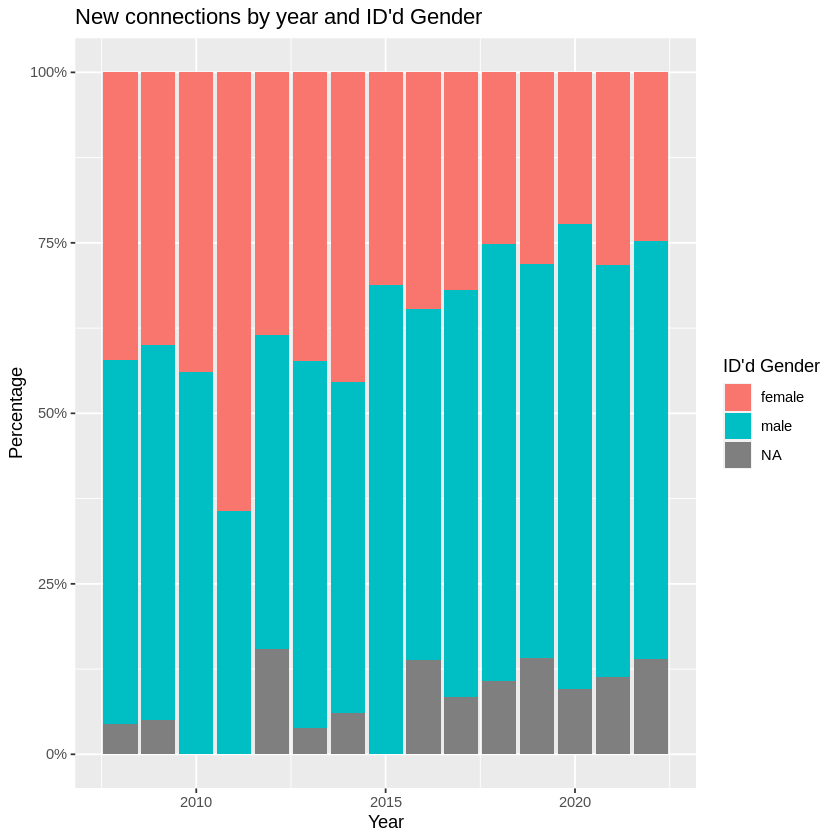

In [ ]:
# Graph showing gender of connections by year added
g <- ggplot(data = fullDF, aes(x = year, fill = gender)) +
  geom_bar(position="fill") +
  labs(x = "Year", y = "Percentage", fill = "ID'd Gender",
    title = "New connections by year and ID'd Gender") +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"))

g

In [ ]:
# Graph cumulative percentage of female connections
#Manipulate the data -- note: this is defninitely not the most elegant approach
cummPercent <- fullDF  %>% 
  select(gender, year) %>% 
  group_by(year, gender) %>% 
  summarise(n = n()) %>%
  ungroup() %>%
  spread(gender, n) %>%
  mutate(total = female + male, # ommitting NA
    cummTot = cumsum(total), 
    cummFemale = cumsum(female),
    cummPercent = cummFemale / cummTot)

cummPercent

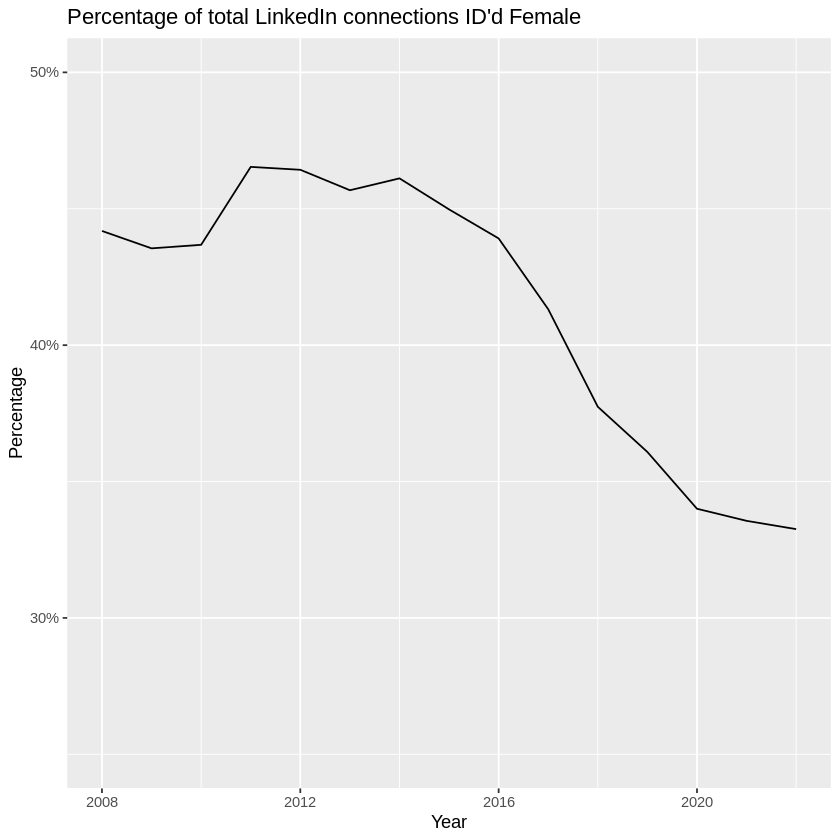

In [ ]:
#Plot percentage
g2 <- ggplot() + 
  geom_line(data = cummPercent, aes(year, y = cummPercent)) + 
  labs(title = "Percentage of total LinkedIn connections ID'd Female", y = "Percentage", x = "Year")  +
  scale_y_continuous(labels = function(x) paste0(x*100, "%"),
    breaks = c(0.2, 0.3, 0.4, 0.5), limits = c(0.25, 0.50)) # You may need to change the limits if your % female is < 25% or > 50%
g2

# References
[1] https://www.linkedin.com/help/linkedin/answer/a566336/export-connections-from-linkedin?lang=en

[2] https://cran.r-project.org/web/packages/gender/gender.pdf

[3] https://cran.r-project.org/web/packages/gender/vignettes/predicting-gender.html

[4] https://www.ssa.gov/oact/babynames/limits.html